In [1]:
from IPython.core.display import HTML
with open('../style.css') as file:
    css = file.read()
HTML(css)

# Handwritten Digit Recognition using $k$-Nearest Neighbours

This notebook uses the <em style="color:blue;">$k$-nearest neighbours algorithm</em> to recognize handwritten digits.  The digits we want to recognize
are stored as images of size $28 \times 28$ pixels.  Each pixel $p$ is stored as a number that satisfies $0 \leq p \leq 1$.  The pixel values are 
interpreted as grey values: If $p = 1.0$, the pixel is completely black, while $p = 0.0$ if the pixel is white.  The images are stored in the file `mnist.pkl.gz`.  This file is compressed using `gzip` and the images have been *pickled* using the module `pickle`.  The module `pickle` supports the reading and writing of *Python* data structures.  

In order to read the images of the handwritten digits, we therefore have to import the modules `gzip` and `pickle`.  The module `numpy` is needed to store the images as arrays.

In [4]:
import gzip
import pickle
import numpy as np

The function `load_data` returns a tuple of the form
$$ (\texttt{X_train}, \texttt{X_test}, \texttt{Y_train}, \texttt{Y_test}) $$
where 
<ul>
<li> $\texttt{X_train}$ is a matrix storing the 50,000 training images of handwritten digits.
     For each $i \in \{0,\cdots,49\,999\}$ the row $\texttt{X_train}[i, :]$ is an array of size $784$ storing a single image.
     </li>
<li> $\texttt{X_test}$ is a matrix containing 10,000 images of handwritten digits that can be used for testing.</li>
<li> $\texttt{Y_train}$ is an array of size 50,000. For each $i \in \{0,\cdots,49\,999\}$ the number $\texttt{Y_train}[i]$
     specifies the digit shown in the $i$th training image.
     </li>
<li> $\texttt{Y_test}$ is an array of size 10,000. For each $i \in \{0,\cdots,9\,999\}$ the number $\texttt{Y_test}[i]$
     specifies the digit shown in the $i$th test image.
     </li>
</ul>

In [2]:
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train, _, test = pickle.load(f, encoding="latin1")
    return (train[0], test[0], train[1], test[1])

In [5]:
X_train, X_test, Y_train, Y_test = load_data()

Let us check what we have read:

In [6]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((50000, 784), (10000, 784), (50000,), (10000,))

Let us inspect the first hand written image of a digit.

In [7]:
X_train[0, :]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

This is an array with 784 entries.  Let us draw the corresponding picture.

In [8]:
import matplotlib.pyplot as plt

The function $\texttt{show_digit}(\texttt{row}, \texttt{columns}, \texttt{offset})$ 
shows $\texttt{row} \cdot \texttt{columns}$ images of the training data.  The first image shown is the image at index $\texttt{offset}$.

In [9]:
def show_digits(rows, columns, offset=0):
    f, axarr = plt.subplots(rows, columns)
    for r in range(rows):
        for c in range(columns):
            i     = r * columns + c + offset
            image = 1 - X_train[i, :]
            image = np.reshape(image, (28, 28))
            axarr[r, c].imshow(image, cmap="gray")
            axarr[r, c].axis('off')
    plt.savefig("digits.pdf")    
    plt.show()

We take a look at the first 24 images.

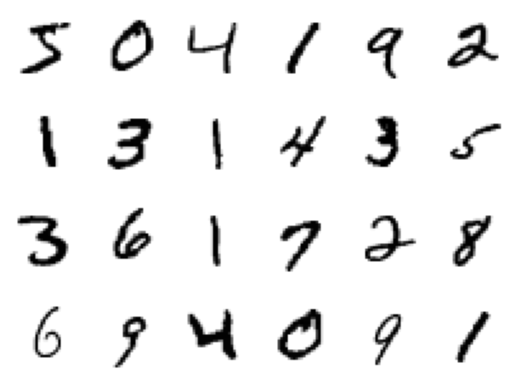

In [10]:
show_digits(4, 6)

Given two arrays $\mathbf{x}$ and $\mathbf{y}$ of the same dimension $n$, the function $\texttt{distance}(\mathbf{x}, \mathbf{y})$ computes the
<em style="color:blue;">Euclidean distance</em> between $\mathbf{x}$ and $\mathbf{y}$.  This distance is defined as follows:
$$ \sqrt{\sum\limits_{i=1}^n (x_i - y_i)^2} $$

In [11]:
def distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

For example, the distance between the first two images of the training set is computed as follows:

In [12]:
distance(X_train[0,:], X_train[1,:])

9.324655

The distance between the 9th and the 15th image should be smaller, because both of these images show the digit $1$ and hence these images are quite similar.
This similarity results in a smaller distance between these images.

In [13]:
distance(X_train[8,:], X_train[14,:])

3.684565

In [17]:
D = {}
D['a'] = 1
D['b'] = 2
D['a'] = 7
D

{'a': 7, 'b': 2}

Given a list $L$ of digits, the function $\texttt{maxCounts}(L)$ returns a pair $(d, p)$ where $d$ is the digit that occurs most frequently in $L$
and $p$ is the percentage of occurrences of $d$ in $L$.  For example, we have
$$ \texttt{maxCounts}([5,2,3,5,2,5,6,5,7,8]) = (5, 0.4)  $$
because the digit $5$ is the most frequent digit in the list $[5,2,3,5,2,5,6,5,7,8]$ and $40$% of the digits in this list are fives.

In [18]:
def maxCount(L):
    Frequencies         = {}    # number of occurrences for each digit
    most_frequent       = L[0]  # most frequent digit so far
    most_frequent_count = 1     # number of occurrences of most frequent digit
    for d in L:
        if d in Frequencies:
            Frequencies[d] += 1
        else:
            Frequencies[d]  = 1
        if Frequencies[d] > most_frequent_count:
            most_frequent       = d
            most_frequent_count = Frequencies[d]
    return most_frequent, most_frequent_count / len(L)

In [19]:
maxCount([3, 3, 4, 2, 1, 2, 3, 2, 5, 3])

(3, 0.4)

Given an image of a digit stored in the vector $\mathbf{x}$ and a number of neighbours $k$, the function $\texttt{digit}(\mathbf{x}, k)$ computes those
$k$ images in the training set `X_train` that are <em style="color:blue;">closest</em> to the image $\mathbf{x}$.  Here 
<em style="color:blue;">closeness</em> of images is defined in terms of the <em style="color:blue;">Euclidean distance</em> of the vectors that store the 
images.  From these $k$ images of the training set the function chooses the digit that occurs most frequently.  It returns a pair $(d, p)$ where $d$ is the digit that is most frequently occurring in the list of $k$ neighbours and $p$ is the percentage of images in the $k$ neighbours of $\mathbf{x}$ that show
the digit $d$.

In [20]:
def digit(x, k):
    n          = X_train.shape[0]  # number of all training images
    Distances  = [ (distance(X_train[i, :], x), i) for i in range(n)]
    Neighbours = [ Y_train[i] for _, i in sorted(Distances)]
    return maxCount(Neighbours[:k])

The function `show_image(n)` shows the $n^\mathrm{th}$ test image.

In [21]:
def show_image(n):
    image = 1 - X_test[n, :]
    image = np.reshape(image, (28, 28))
    plt.imshow(image, cmap="gray")
    plt.show()

This function performs $k$-nearest neighbour classification for the $n$-th image of the test set.  It also prints the image.

In [22]:
def test(n, k):
    print(f'Testing image {n}:')
    show_image(n)
    d, p = digit(X_test[n, :], k)
    print(f'I believe with a certainty of {p * 100}% that the image shows the digit {d}.')

Testing image 2:


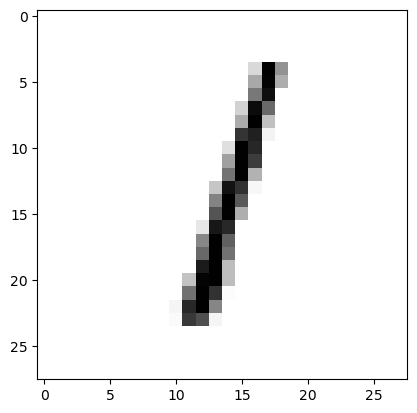

I believe with a certainty of 100.0% that the image shows the digit 1.


In [23]:
test(2, 13)

Let us classify the first 20 images from the test set.

Testing image 0:


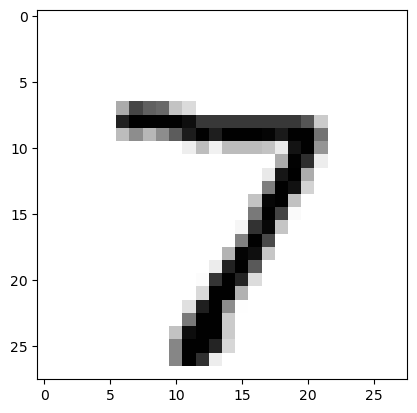

I believe with a certainty of 100.0% that the image shows the digit 7.
Testing image 1:


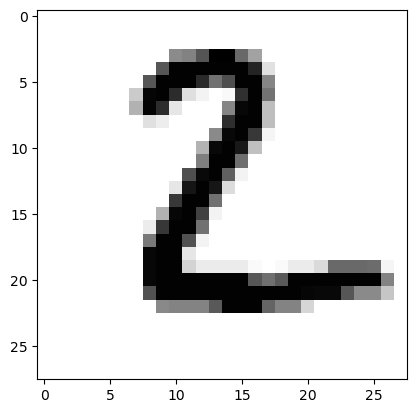

I believe with a certainty of 100.0% that the image shows the digit 2.
Testing image 2:


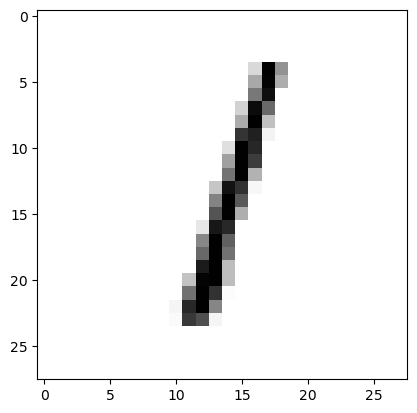

I believe with a certainty of 100.0% that the image shows the digit 1.
Testing image 3:


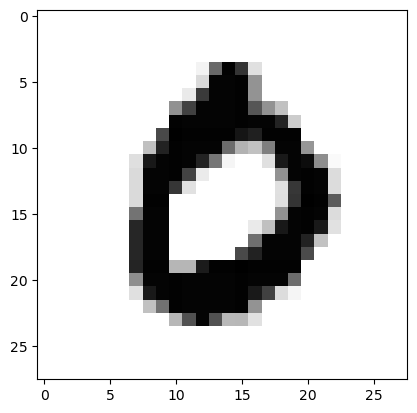

I believe with a certainty of 100.0% that the image shows the digit 0.
Testing image 4:


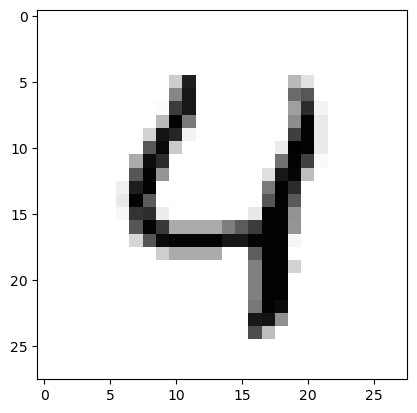

I believe with a certainty of 92.3076923076923% that the image shows the digit 4.
Testing image 5:


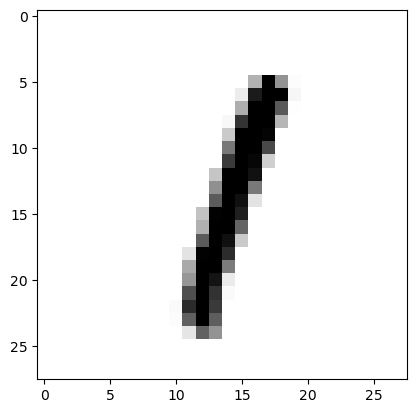

I believe with a certainty of 100.0% that the image shows the digit 1.
Testing image 6:


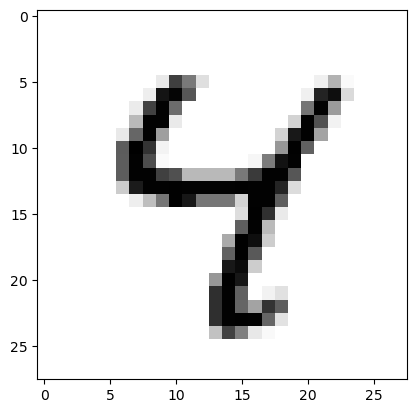

I believe with a certainty of 92.3076923076923% that the image shows the digit 4.
Testing image 7:


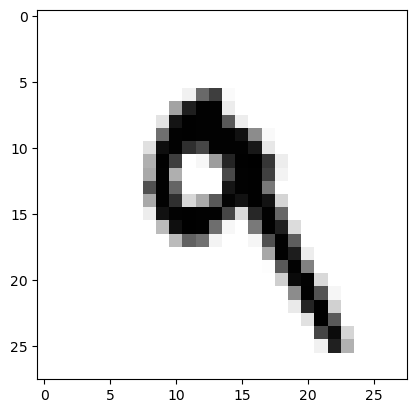

I believe with a certainty of 100.0% that the image shows the digit 9.
Testing image 8:


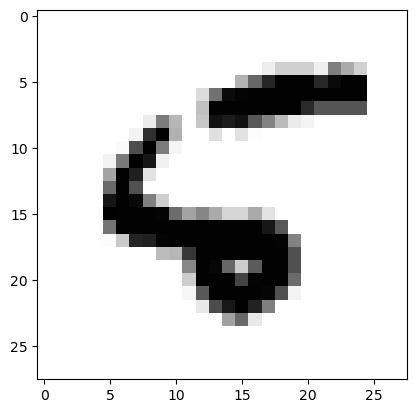

I believe with a certainty of 53.84615384615385% that the image shows the digit 5.
Testing image 9:


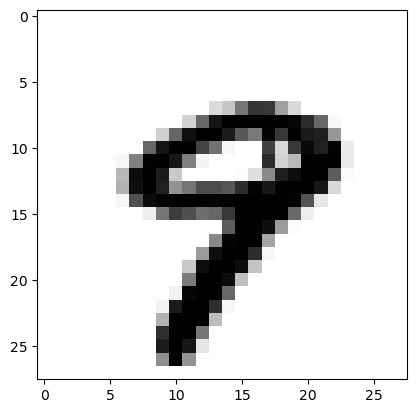

I believe with a certainty of 92.3076923076923% that the image shows the digit 9.
Testing image 10:


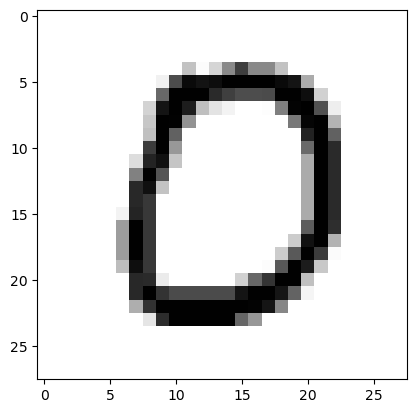

I believe with a certainty of 100.0% that the image shows the digit 0.
Testing image 11:


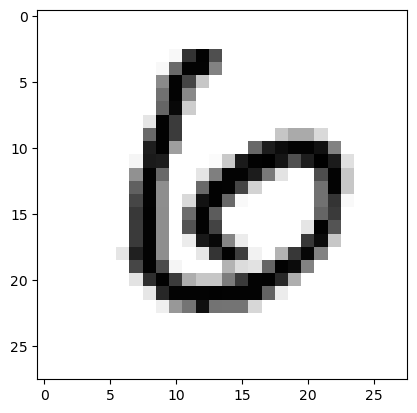

I believe with a certainty of 100.0% that the image shows the digit 6.
Testing image 12:


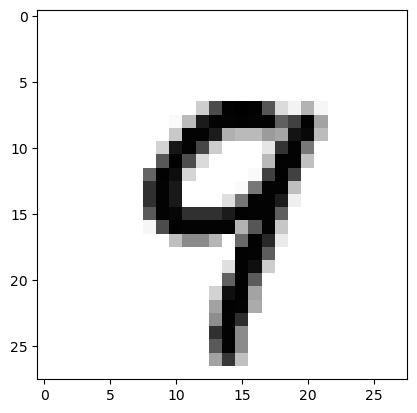

I believe with a certainty of 100.0% that the image shows the digit 9.
Testing image 13:


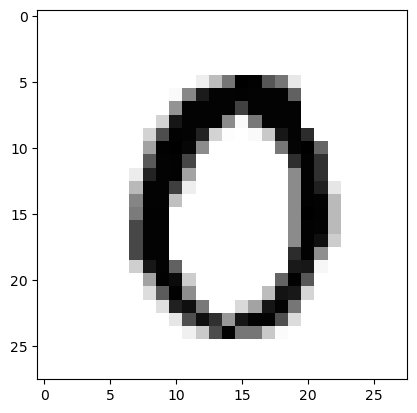

I believe with a certainty of 100.0% that the image shows the digit 0.
Testing image 14:


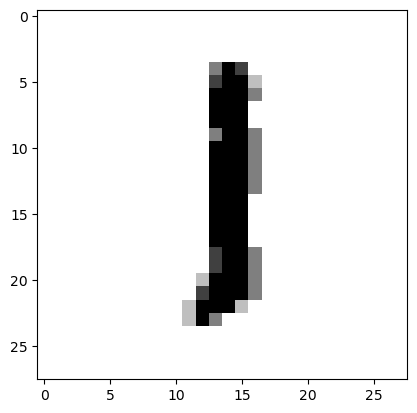

I believe with a certainty of 100.0% that the image shows the digit 1.
Testing image 15:


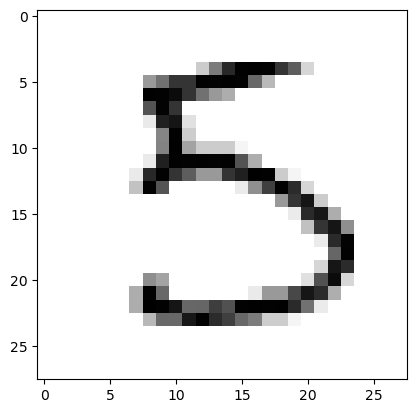

I believe with a certainty of 84.61538461538461% that the image shows the digit 5.
Testing image 16:


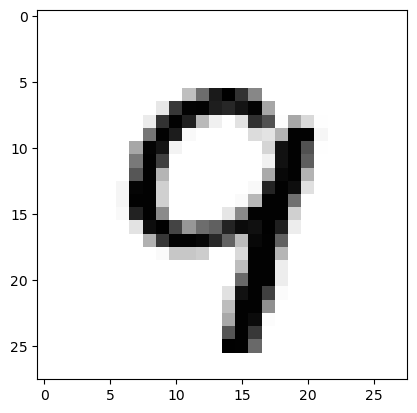

I believe with a certainty of 92.3076923076923% that the image shows the digit 9.
Testing image 17:


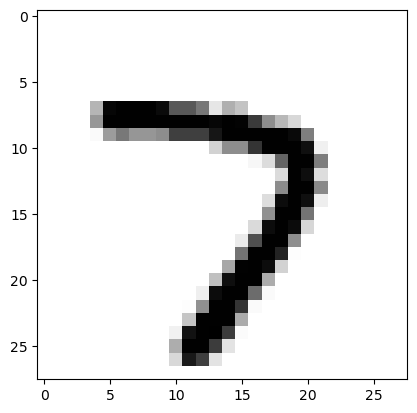

I believe with a certainty of 100.0% that the image shows the digit 7.
Testing image 18:


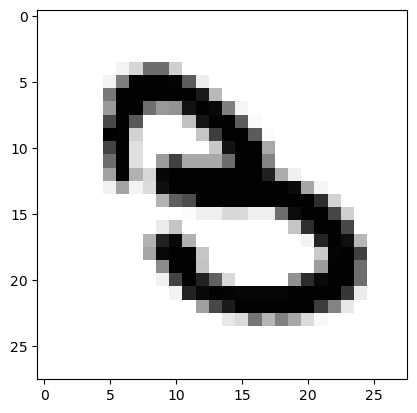

I believe with a certainty of 100.0% that the image shows the digit 3.
Testing image 19:


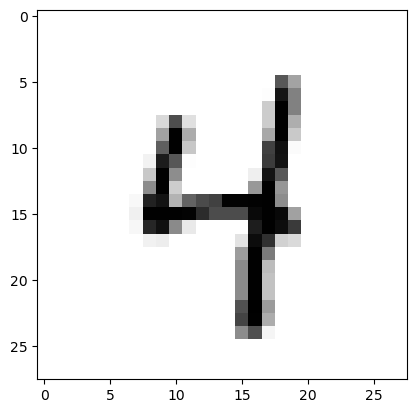

I believe with a certainty of 100.0% that the image shows the digit 4.
CPU times: user 48.8 s, sys: 2.75 s, total: 51.6 s
Wall time: 11.6 s


In [24]:
%%time
for n in range(20):
    test(n, 13)

Let us check how much memory is used at the moment.  The function call below prints all the memory of our machine that is currently used.

In [25]:
def check(n, k):
    d, p = digit(X_test[n, :], k)
    if d == Y_test[n]:
        return 0
    else:
        print(f"\nImage number {n} wrongly identified: I guessed a {d}, but it's a {Y_test[n]}.")
        show_image(n)
        return 1


Image number 43 wrongly identified: I guessed a 1, but it's a 2.


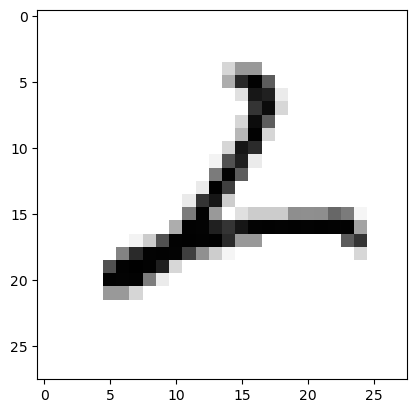


Image number 77 wrongly identified: I guessed a 7, but it's a 2.


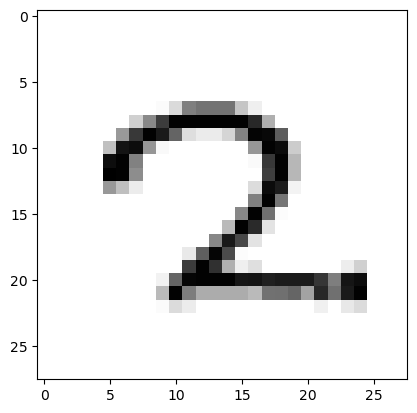


Image number 115 wrongly identified: I guessed a 9, but it's a 4.


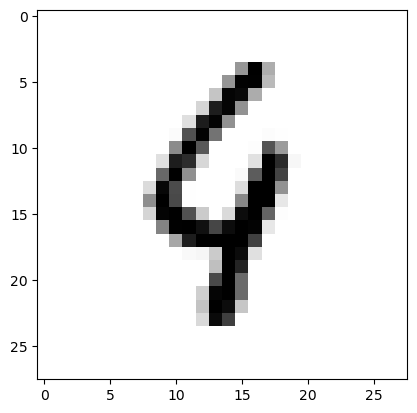


Image number 195 wrongly identified: I guessed a 1, but it's a 3.


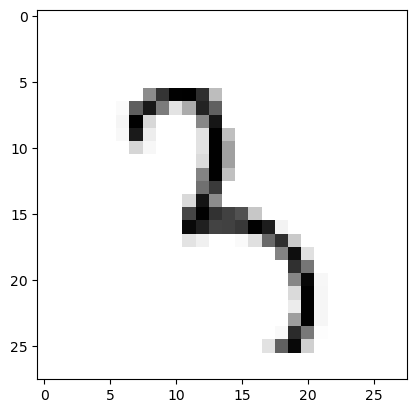


Image number 241 wrongly identified: I guessed a 8, but it's a 9.


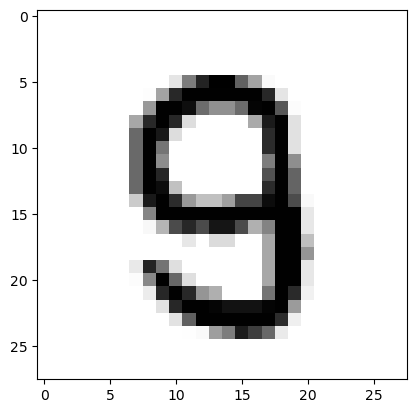


Image number 247 wrongly identified: I guessed a 6, but it's a 4.


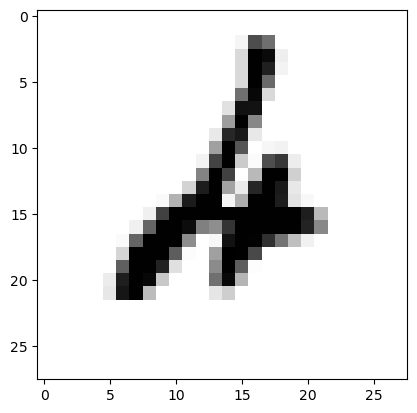


Image number 300 wrongly identified: I guessed a 1, but it's a 4.


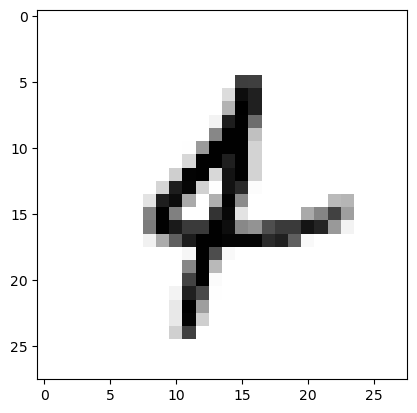


Image number 318 wrongly identified: I guessed a 0, but it's a 2.


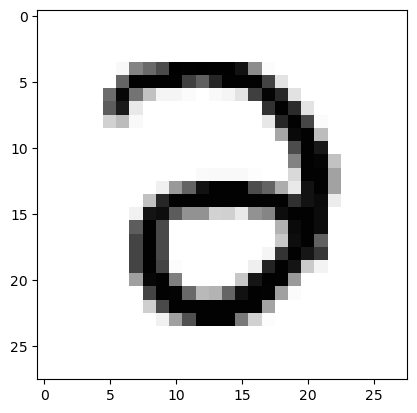


Image number 320 wrongly identified: I guessed a 7, but it's a 9.


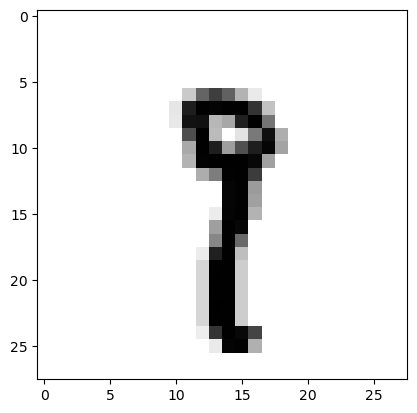


Image number 321 wrongly identified: I guessed a 7, but it's a 2.


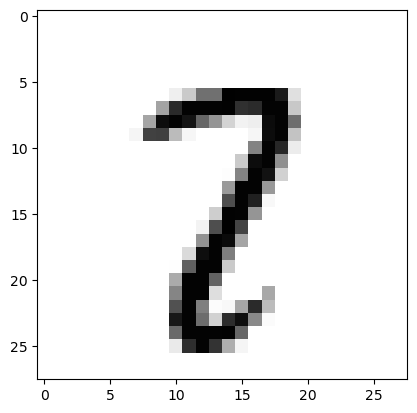


Image number 341 wrongly identified: I guessed a 4, but it's a 6.


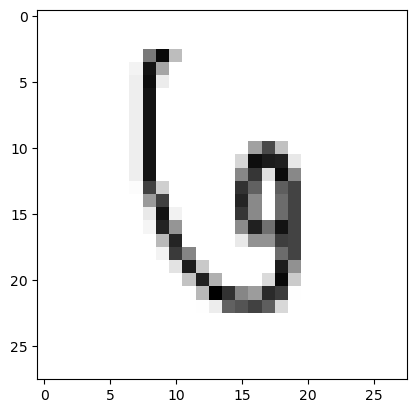


Image number 358 wrongly identified: I guessed a 4, but it's a 7.


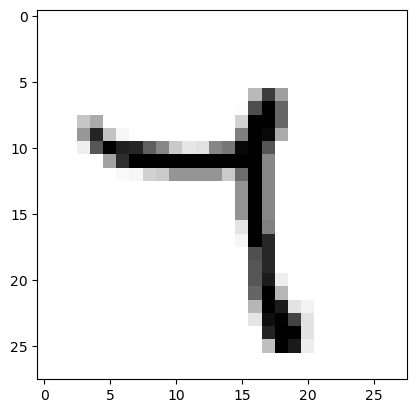


Image number 376 wrongly identified: I guessed a 9, but it's a 4.


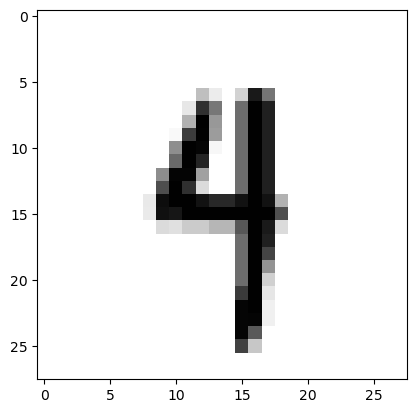


Image number 381 wrongly identified: I guessed a 7, but it's a 3.


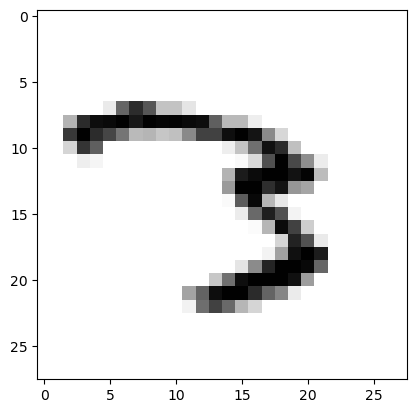

In [ ]:
%%time
errors = 0
for n in range(10_000):
    errors += check(n, 7)
print(f'There were {errors} errors out of 10000 images.')